# Fit Instrument transmission using Gaussian Processes 

The purpose is to fit Bouguer lines to find Instrument transmission


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : September 22th 2020
- update : September 22th 2020

# imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
from astropy.table import Table

In [4]:
from scipy import interpolate

In [5]:
from scipy.stats import rayleigh,beta,gamma,uniform

In [6]:
# analytic for removing rayleigh
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [7]:
import libatmscattering as atm

In [8]:
import seaborn as sns

In [9]:
# pysynphot
import pysynphot as S

In [10]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')

In [11]:
import scipy.special as sp

In [12]:
PATH_LSSTFiltersKG='../../data/lsst/LSSTFiltersKG'
sys.path.append(PATH_LSSTFiltersKG)
PATH_LSSTFiltersKGDATA='../../data/lsst/LSSTFiltersKG/fdata'
sys.path.append(PATH_LSSTFiltersKGDATA)

In [13]:
import libLSSTFiltersKG as lsst

liblsstfilter_path= ../../data/lsst/LSSTFiltersKG


In [14]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser

# Pre defined Functions

In [15]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

## Functions to select the CALSPEC

In [16]:
def GetListOfCalspec(file_sedsummary="sed/table_summary_allcalspec_torenorm.fits"):
    """
    GetListOfCalspec()
    
    the file include SED fro which color term has been caculated 
    in /examples_sed/calspec/ViewCalspecColors.ipynb
    
    - input:
      file_sedsummary : filename of SED summary
      
    - output:
      t : astropy table of summary 
    """

    t=Table.read(file_sedsummary)
    return t

In [17]:
def SelectFewSED(t):
    """
    SelectFewSED(t)
    
    input : 
     - t astropy table of SED
     
    output :
    - t_selected : table of presselected SED
     
    """
    
    all_colors=t["VmI"]
    
    
    # list of target colors
    target_VmI=np.array([-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1])
    NBVmItarget=len(target_VmI)
    
    filesselected_index=np.zeros(NBVmItarget)
    filesselected_VmI=np.zeros(NBVmItarget)
    
    idx=0
    for vmi in target_VmI:
        thevmi,theidx=find_nearest(all_colors,vmi)
        #print(thevmi,theidx)
        filesselected_index[idx]=int(theidx)
        filesselected_VmI[idx]=thevmi
        idx+=1  
        
    t_selected=Table(t[0])
    for idx in filesselected_index[1:]:
        t_selected.add_row(t[int(idx)])
        
    return t_selected
    

In [18]:
def plot_sed(t,ax):
    """
    
    plot_sed(t, ax) : Plot SED from the astropy table t

    input:
        - t : tables of SED
        - ax : matplotlib axis

    """
    
    NBFILES=len(t)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NBFILES)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NBFILES), alpha=1)
    
    idx=0
    
    flatsp = S.FlatSpectrum(10, fluxunits='photlam')

    for filename in t["FILES"]:
    
        # read the calspec file
        fullfilename=os.path.join(path_sed_calspec,filename)
        
        if filename=="flat":
            spec=flatsp
            spec_norm=spec
        else:
            spec=S.FileSpectrum(fullfilename)
        
        spec_norm = spec.renorm(10, 'vegamag', S.ObsBandpass('johnson,v'))
    
        spec_norm.convert('photlam')
        #spec_norm.convert('nm')    
        
        #WLMINSEL=340.
        #WLMAXSEL=1100.


        magV=t["magV"][idx]
        label=t["OBJNAME"][idx]+" ( "+t["SP_TYPE"][idx]+" ) "+" magV = {:.2g}".format(magV) +" v-i ={:.2f}".format(t["VmI"][idx])
        
        
        
        #X= spec_norm.wave[wavelengths_indexes]    
        #Y= spec_norm.flux[wavelengths_indexes]  
        
        X= spec_norm.wave   
        Y= spec_norm.flux 
        
        wavelengths_indexes=np.where(np.logical_and(spec_norm.wave>WLMINSEL*10, spec_norm.wave<WLMAXSEL*10))[0]
        
        
        #if filename!="flat":
        cm=ax.plot(X[wavelengths_indexes], Y[wavelengths_indexes],color=all_colors[idx],label=label)
        
        idx+=1
    
    #ax.set_xlim(3500.,11000.)
    #ax.set_ylim(0.,3.)
    ax.legend()
    ax.grid()


    xlabel=' $\\lambda$ (Angstrom)'
    ylabel=' Flux (photlam) normalised to Mag-10'
    ax.set_xlabel(xlabel,fontsize=15)
    ax.set_ylabel(ylabel,fontsize=15)
    ax.set_title("Preselected CALSPEC relative SED")
    
    return cm

    
    

## Functions to build spectrum 

In [19]:
def GetSpectra(sed,wl_atm,atm_transmission, order2=False,cut=False):
    """
    
    * input : 
     - sed : Pysynphot SED
     -  wl  : wavelength of the atmospheric transmission (nm)
     - transmission : atmospheric transmission array
     - order2 : flag to compute the atmospheric transmission
     
    * output :
     - array of spectra (corresponding to wl in nm)
    
    """
    
    wl0=sed.wave  # in angstrom
    spectra=np.zeros_like(atm_transmission)
    spectra2=np.zeros_like(atm_transmission)  # order 2
    
    wl_atm_ang=10*wl_atm
    
    
    
    # quantum efficiency
    wl_ccd,throughput,ccdqe,trans_opt_elec=lsst.GetThroughputAndCCDQE("../../data/lsst")
    bp_qe= S.ArrayBandpass(wl_ccd*10.,ccdqe, name='QE')
    
    
    
    # passband for atmosphere
    Natm=atm_transmission.shape[0]
    all_bp_atm=[]
    for i_atm in np.arange(Natm):
        label_atm="atm{:d}".format(i_atm)
        bp_atm= S.ArrayBandpass(wl_atm_ang,atm_transmission[i_atm,:], name=label_atm)
        all_bp_atm.append(bp_atm)
        
    # Hologram transmission (analytic)
    X0=10000 # in antstrom
    X=wl0
    X2=np.sort(np.unique(np.concatenate((wl0/2,wl0)))) 
    Eff_holo=sp.jv(1, X0/X)**2
    Eff_holo2=sp.jv(2, X0/X2)**2
    
    bp_holo_order1= S.ArrayBandpass(X,Eff_holo, name='Holo')
    bp_holo_order2= S.ArrayBandpass(X2,Eff_holo2, name='Holo2')
    
    all_obs1=[]
    all_obs2=[]
    
    # compute spectra for order 1 and order 2
    for i_atm in np.arange(Natm):
        bp_all_order1=bp_qe*all_bp_atm[i_atm]* bp_holo_order1
        bp_all_order2=bp_qe*all_bp_atm[i_atm]* bp_holo_order2

        obs1 = S.Observation(sed, bp_all_order1,force='taper') # order 1
        obs2 = S.Observation(sed, bp_all_order2,force='taper') # order 2
    
        all_obs1.append(obs1)
        all_obs2.append(obs2)
        
   
    for i_atm in np.arange(Natm):
        obs1=all_obs1[i_atm]
        func_order1 = interpolate.interp1d(obs1.binwave,obs1.binflux,bounds_error=False,fill_value=(0,0))
    
        spectra[i_atm,:]=func_order1(wl_atm_ang) 
    
        obs2=all_obs2[i_atm]
        func_order2 = interpolate.interp1d(2*obs2.binwave,obs2.binflux/2,bounds_error=False,fill_value=(0,0))
        spectra2[i_atm,:]=func_order2(wl_atm_ang) 
      
    if cut:
        wlcut_indexes = np.where(wl_atm_ang<7600)[0]
        spectra2[wlcut_indexes]=0
        
    # add order 1 + order 2    
    if order2:
        spectra=spectra+spectra2
        
    spectra=spectra*10 # to get per unit of nm
    spectra2=spectra2*10
    
    return spectra,spectra2
    
    

In [20]:
def GetSpectraNoAtm(sed,wl_atm,atm_transmission, order2=False,cut=False):
    """
    
    * input : 
     - sed : Pysynphot SED
     -  wl  : wavelength of the atmospheric transmission (nm)
     - transmission : atmospheric transmission array
     - order2 : flag to compute the atmospheric transmission
     
    * output :
     - array of spectra (corresponding to wl in nm)
    
    """
    
    wl0=sed.wave  # in angstrom
    spectra=np.zeros_like(atm_transmission)
    spectra2=np.zeros_like(atm_transmission)  # order 2
    
    wl_atm_ang=10*wl_atm
    
    
    
    # quantum efficiency
    wl_ccd,throughput,ccdqe,trans_opt_elec=lsst.GetThroughputAndCCDQE("../../data/lsst")
    bp_qe= S.ArrayBandpass(wl_ccd*10.,ccdqe, name='QE')
    
    
    
    # passband for atmosphere
    Natm=atm_transmission.shape[0]
    all_bp_atm=[]
    for i_atm in np.arange(Natm):
        label_atm="atm{:d}".format(i_atm)
        bp_atm= S.ArrayBandpass(wl_atm_ang,atm_transmission[i_atm,:], name=label_atm)
        all_bp_atm.append(bp_atm)
        
    # Hologram transmission (analytic)
    X0=10000 # in antstrom
    X=wl0
    X2=np.sort(np.unique(np.concatenate((wl0/2,wl0)))) 
    Eff_holo=sp.jv(1, X0/X)**2
    Eff_holo2=sp.jv(2, X0/X2)**2
    
    bp_holo_order1= S.ArrayBandpass(X,Eff_holo, name='Holo')
    bp_holo_order2= S.ArrayBandpass(X2,Eff_holo2, name='Holo2')
    
    all_obs1=[]
    all_obs2=[]
    
    # compute spectra for order 1 and order 2
    # remoove atmosphere and qe
    # keep  hologram
    for i_atm in np.arange(Natm):
        #bp_all_order1=bp_qe*all_bp_atm[i_atm]* bp_holo_order1
        #bp_all_order2=bp_qe*all_bp_atm[i_atm]* bp_holo_order2
        
        bp_all_order1 = bp_holo_order1
        bp_all_order2 = bp_holo_order2

        obs1 = S.Observation(sed, bp_all_order1,force='taper') # order 1
        obs2 = S.Observation(sed, bp_all_order2,force='taper') # order 2
    
        all_obs1.append(obs1)
        all_obs2.append(obs2)
        
   
    for i_atm in np.arange(Natm):
        obs1=all_obs1[i_atm]
        func_order1 = interpolate.interp1d(obs1.binwave,obs1.binflux,bounds_error=False,fill_value=(0,0))
    
        spectra[i_atm,:]=func_order1(wl_atm_ang) 
    
        obs2=all_obs2[i_atm]
        func_order2 = interpolate.interp1d(2*obs2.binwave,obs2.binflux/2,bounds_error=False,fill_value=(0,0))
        spectra2[i_atm,:]=func_order2(wl_atm_ang) 
        
    if cut:
        wlcut_indexes = np.where(wl_atm_ang<7600)[0]
        spectra2[wlcut_indexes]=0
        
    # add order 1 + order 2    
    if order2:
        spectra=spectra+spectra2
        
    spectra=spectra*10 # to get per unit of nm
    spectra2=spectra2*10
    
    return spectra,spectra2
    
    

## Functions for Plotting

In [21]:
def plot_param(iparam,ax,all_Yin,all_Yout,mode,nsig=10):
    """
    plot estimated parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    xlabel=["VAOD in ","PWV in (mm)","Ozone in (dBU)","Cloud OD in "]
    ylabel=["value out","value rec - value in","$\delta V/V$"]
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]
     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    
    if mode   ==0:  
        cm=ax.plot(Y0,Y1,"o",color=all_colors[iparam])
    elif mode ==1:
        
        mu = DY.mean()
        median = np.median(DY)
        sigma = DY.std()
        textstr = '\n'.join((
        r'$\mu$={:3.2g}'.format(mu),
        r'$median$={:3.2g}'.format(median),
        r'$\sigma$={:3.2g}'.format(sigma)))
        
       
        cm=ax.plot(Y0,DY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        
        ax.set_ylim(mu-nsig*sigma,mu+nsig*sigma)
        
    else:
        
        mu = RY.mean()
        median = np.median(RY)
      
        sigma = RY.std()
        
        
        textstr = '\n'.join((
        '$\mu$={:.3g}'.format(mu),
        '$median$={:.3g}'.format(median),
        '$\sigma$={:.3g}'.format(sigma)))
       
        
        
        cm=ax.plot(Y0,RY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
            
        ax.set_ylim(mu-nsig*sigma,mu+nsig*sigma)    
            
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_ylabel(ylabel[mode])

    
    ax.ticklabel_format(axis='y',style='sci', 
                          scilimits=None, 
                          useOffset=None, 
                          useLocale=None, 
                          useMathText=True)
    
    return cm
    

In [22]:
def plot_param_histo(iparam,ax,all_Yin,all_Yout,nsig=10):
    """
    plot histo of parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    

    xlabel=["$\Delta$ VAOD","$\Delta$ PWV (mm)","$\Delta$ Ozone (dBU)","$\Delta$ OD"]
   
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]

    
    mu = DY.mean()
    median = np.median(DY)
    sigma = DY.std()
    textstr = '\n'.join((
    '$\mu$={:.3g}'.format(mu),
    '$median$={:.3g}'.format(median),
    '$\sigma$={:.3g}'.format(sigma)))
   
    
    cm=ax.hist(DY,bins=50,color=all_colors[iparam])
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_xlim(mu-nsig*sigma,mu+nsig*sigma)
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
 
    ax.ticklabel_format(axis='x', 
                          style='sci',
                          scilimits=(-3,-3), 
                          useOffset=None, 
                          useLocale=None, 
                          useMathText=True)
    
    return cm
    

In [23]:
def plotcorrelation(ax,all_Y):
    """
    """
    
    df=pd.DataFrame(data=all_Y,columns=['VAOD', 'PWV', 'OZONE',"CLD-OD"])
    Var_Corr = df.corr()
    mask_ut=np.triu(np.ones(Var_Corr.shape)).astype(np.bool)
    mask_lt=np.logical_not(np.tril(np.ones(Var_Corr.shape)).astype(np.bool))
    
    sns.heatmap(Var_Corr,mask=mask_lt,vmin=0, vmax=1 ,xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True,ax=ax,cmap="jet")

In [24]:
#-----------------------------------------------------------------------------------------------------------------------
def plot_ml_result(Yin,Yout,mode,title):
    """
    plot_ml_result(Yin,Yout,mode,title)

    :param Yin:
    :param Yout:
    :param mode:
    :param title:
    :return:
    """

    fig = plt.figure(figsize=(8.5, 7.5))
    ax = fig.add_subplot(221)
    plot_param(0, ax, Yin, Yout, mode)

    ax = fig.add_subplot(222)
    plot_param(1, ax,Yin, Yout, mode)

    ax = fig.add_subplot(223)
    plot_param(2, ax, Yin, Yout, mode)

    ax = fig.add_subplot(224)
    plot_param(3, ax, Yin, Yout, mode)

    plt.tight_layout()
    plt.suptitle(title, Y=1.02, fontsize=18)
    plt.show()
#--------------------------------------------

In [25]:
def histo_ml_result(Yin, Yout, title):
    """

    :param Yin:
    :param Yout:
    :param mode:
    :param title:
    :return:
    """

    fig = plt.figure(figsize=(8.5, 7.5))
    ax = fig.add_subplot(221)
    plot_param_histo(0, ax, Yin, Yout)

    ax = fig.add_subplot(222)
    plot_param_histo(1, ax, Yin, Yout)

    ax = fig.add_subplot(223)
    plot_param_histo(2, ax, Yin, Yout)

    ax = fig.add_subplot(224)
    plot_param_histo(3, ax, Yin, Yout)

    plt.tight_layout()
    plt.suptitle(title, Y=1.02, fontsize=18)
    plt.show()
#---------------------------------------------

In [26]:
def plot_regularisation_coeff(alphas,alpha0,allcoefs,title):
    """

    plot_regularisation_coeff(alpha,all_coeff,title) : plot coefficient vrt regularisation parameter

    :param alphas: regularisation parameters
    : param alpha0 : vertical line
    :param allcoefs: coefficient
    :param title: title
    :return:
    """

    N = allcoefs.shape[2] # number of coefficients
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    fig = plt.figure(figsize=(12, 8))

    ax1 = fig.add_subplot(221)
    for idx in np.arange(allcoefs.shape[2]):
        ax1.plot(alphas, allcoefs[:, 0, idx], color=all_colors[idx])
    ax1.set_xscale('log')
    ax1.axvline(x=alpha0, color='red')
    ax1.set_ylabel('weights - vaod')
    ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
    ax1.grid(True)
    ax1.set_title(title)

    ax2 = fig.add_subplot(222, sharex=ax1)
    for idx in np.arange(allcoefs.shape[2]):
        ax2.plot(alphas, allcoefs[:, 1, idx], color=all_colors[idx])
    ax2.axvline(x=alpha0, color='red')
    ax2.set_xscale('log')
    ax2.set_ylabel('weights - H2O')
    ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
    ax2.grid(True)

    ax3 = fig.add_subplot(223, sharex=ax1)
    for idx in np.arange(allcoefs.shape[2]):
        ax3.plot(alphas, allcoefs[:, 2, idx], color=all_colors[idx])
    ax3.axvline(x=alpha0, color='red')
    ax3.set_ylabel('weights - O3')
    ax3.set_xscale('log')
    ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
    ax3.grid(True)

    ax4 = fig.add_subplot(224, sharex=ax1)
    for idx in np.arange(allcoefs.shape[2]):
        ax4.plot(alphas, allcoefs[:, 3, idx], color=all_colors[idx])
    ax4.axvline(x=alpha0, color='red')
    ax4.set_ylabel('weights - CLD')
    ax4.set_xscale('log')
    # ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
    ax4.set_xlim(ax4.get_xlim())  # reverse axis
    ax4.grid(True)

    plt.xlabel('alpha')
    plt.axis('tight')

    plt.tight_layout()
    plt.show()



# GetAtmTransparency

In [27]:
def GetAtmTransparency(inputdir,filelist):
    """
    GetAtmTransparency(inputdir, filelist): retrieve atmospheric transparency from simulation

    input arguments:
     - inputdir : input directory
     - filelist : list of file to read
    """
    
    filename=filelist[0]
    full_inputfilename=os.path.join(inputdir,filename)
    hduin = fits.open(full_inputfilename)
    
    headerin=hduin[0].header
    datain=hduin[0].data
    
    hdr=headerin
    NSIMH=hdr['NBATMSIM']
    idx_num = hdr['ID_NUM']
    idx_am = hdr['ID_AM']
    idx_vaod=hdr['ID_VAOD']
    idx_pwv= hdr['ID_PWV']
    idx_o3=hdr['ID_O3']
    idx_cld=hdr['ID_CLD']
    idx_res= hdr['ID_RES']
    
    wl=datain[0,idx_res:]
    
    hduin.close() 
    
    all_data=[]
    # loop on files to extract data
    for file in filelist:
        full_inputfilename=os.path.join(inputdir,file)
        hdu = fits.open(full_inputfilename)
       
        datain=hdu[0].data
        all_data.append(datain[1:,:])
        hdu.close
        
    dataout=np.concatenate(all_data,axis=0)
    
    return wl,dataout,idx_num,idx_am,idx_vaod,idx_pwv,idx_o3,idx_cld,idx_res,headerin
        

# Initialisation

In [28]:
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")


# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)


#timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
print("LA time:", datetime_LA.strftime("%H:%M:%S"))


tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
print("NY time:", datetime_NY.strftime("%H:%M:%S"))

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
print("London time:", datetime_London.strftime("%H:%M:%S"))

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
print("Paris time:", datetime_Paris.strftime("%H:%M:%S"))

LA time: 14:34:44
NY time: 17:34:44
London time: 22:34:44
Paris time: 23:34:44


# Configuration

In [29]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')


In [30]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2020-09-22 23:34:44,755 MacBook-Pro-de-admin.local __main__[93411] INFO LA time:14:34:44
2020-09-22 23:34:44,756 MacBook-Pro-de-admin.local __main__[93411] INFO NY time:17:34:44
2020-09-22 23:34:44,758 MacBook-Pro-de-admin.local __main__[93411] INFO London time:22:34:44
2020-09-22 23:34:44,759 MacBook-Pro-de-admin.local __main__[93411] INFO Paris time:23:34:44
2020-09-22 23:34:44,761 MacBook-Pro-de-admin.local __main__[93411] INFO ************************ START *********************


In [31]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""

In [32]:
# config file
# --------------
configfile = "config/default.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2020-09-22 23:34:44,809 MacBook-Pro-de-admin.local __main__[93411] INFO Configuration file : config/default.ini


In [33]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

config_section = config.sections()

2020-09-22 23:34:44,844 MacBook-Pro-de-admin.local __main__[93411] INFO 1) Configuration


In [34]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [35]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT = bool(int(config['GENERAL']['FLAG_PRINT']))
else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)


if 'MLFIT'in config_section:
    input_file = config['MLFIT']['inputfile']
    input_dir = config['MLFIT']['inputdir']

    packetsize = int(config['MLFIT']['packetsize'])
    maxnbpacket = int(config['MLFIT']['maxnbpacket'])

    input_file_split=input_file.split(".")    
    basefilename=input_file_split[0]
    extendfilename=input_file_split[1]
else:
    msg="Configuration file : Missing section MLFIT in config file {config_filename} !"
    logger.error(msg)
    

# Atmospheric transparency file and selection

In [36]:
all_files = os.listdir(input_dir)
sorted_files=sorted(all_files)

In [37]:
# search string
search_str="^"+f"{basefilename}.*fits$"

In [38]:
selected_files=[]
for file in sorted_files:
    if re.search(search_str,file):
        selected_files.append(file)

### Keep a limited number of input files

In [39]:
if maxnbpacket>0:
    selected_files=selected_files[:maxnbpacket]

In [40]:
NFiles=len(selected_files)

# Read simulated atmospheric transparency

In [41]:
wl,datain,idx_num,idx_am,idx_vaod,idx_pwv,idx_o3,idx_cld,idx_res,header=GetAtmTransparency(input_dir,selected_files)

In [42]:
logger.info(header)

2020-09-22 23:34:45,757 MacBook-Pro-de-admin.local __main__[93411] INFO SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  957                                                  NAXIS2  =                  101                                                  NBATMSIM=                20000                                                  ID_NUM  =                    0                                                  ID_AM   =                    1                                                  ID_VAOD =                    2                                                  ID_PWV  =                    3                                                  ID_O3   =                    4                                                  ID_CLD  =                    5                  

In [43]:
num=datain[0:,idx_num]
airmass=datain[0:,idx_am]
vaod=datain[0:,idx_vaod] # vertical aerosol depth
pwv=datain[0:,idx_pwv]   # precipitable water vapor (mm)
ozone=datain[0:,idx_o3]     # ozone
cld=datain[0:,idx_cld]   # clouds (not us

In [44]:
transm=datain[:,idx_res:]

/Users/dagoret/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
2020-09-22 23:34:46,880 MacBook-Pro-de-admin.local matplotlib.legend[93411] WARNING No handles with labels found to put in legend.


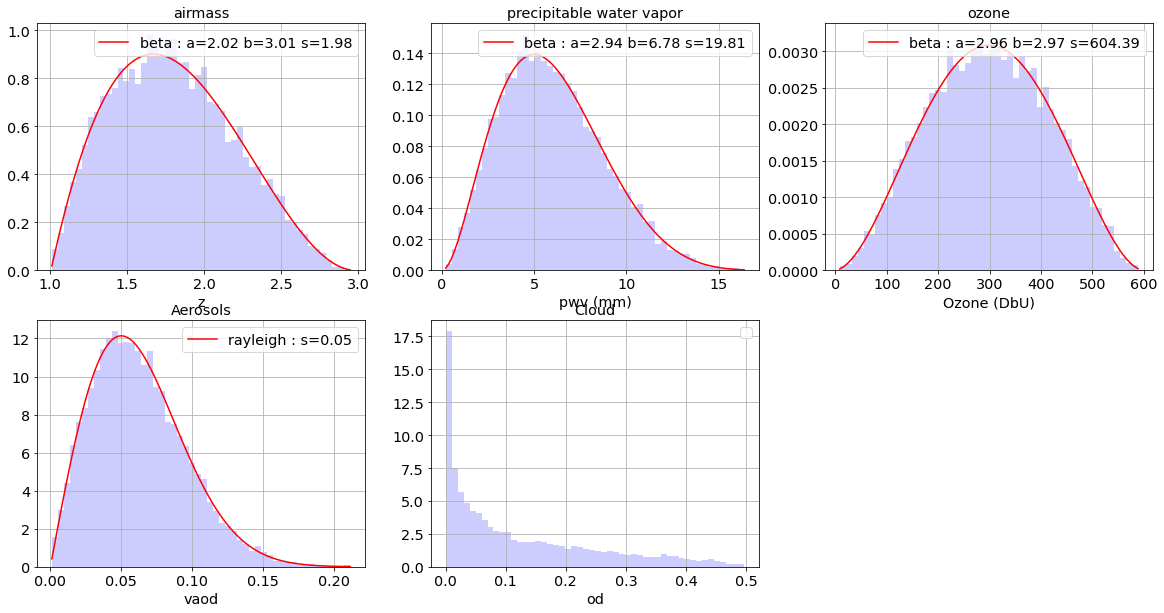

In [45]:
def GetDistribFromName(name):
    """
    
    GetDistribFromName(name): Get distribution from name in config file
    
    input arg:
    
    - name : string name of the distribution
    
    """
    
    rayleigh,beta,gamma,uniform
    
    if name=="rayleigh":
        return rayleigh
    elif name=="beta":
        return beta
    elif name=="gamma":
        return gamma
    else:
        return uniform
    


if FLAG_PLOT:
    fig=plt.figure(figsize=(20,10))
    ax1=fig.add_subplot(231)
    ax2=fig.add_subplot(232)
    ax3=fig.add_subplot(233)
    ax4=fig.add_subplot(234)
    ax5=fig.add_subplot(235)
    #ax6=fig.add_subplot(326)

    
    
    ax1.hist(airmass,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax1.set_title("airmass")
    ax1.set_xlabel("z")
    
    
    if 'AIRMASS' in config_section:
        distrib_name= config['AIRMASS']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(airmass)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(airmass.min(),airmass.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        ax1.plot(x,pdf,"r-",label=label)
        ax1.legend()
        ax1.grid()
    
    
    
    
    ax2.hist(pwv,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax2.set_title("precipitable water vapor")
    ax2.set_xlabel("pwv (mm)")
    
    if 'PWV' in config_section:
        distrib_name= config['PWV']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(pwv)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(pwv.min(),pwv.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        ax2.plot(x,pdf,"r-",label=label)
        ax2.legend()
        ax2.grid()
    
        
    
    ax3.hist(ozone,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax3.set_title("ozone")
    ax3.set_xlabel("Ozone (DbU)")
    
    if 'OZONE' in config_section:
        distrib_name= config['OZONE']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(ozone)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(ozone.min(),ozone.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        ax3.plot(x,pdf,"r-",label=label)
        ax3.legend()
        ax3.grid()
    
    
    
    ax4.hist(vaod,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax4.set_title("Aerosols")
    ax4.set_xlabel("vaod")
    
    
    if 'AEROSOL' in config_section:
        distrib_name= config['AEROSOL']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(vaod)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(vaod.min(),vaod.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : s={:2.2f}".format(scale)
        ax4.plot(x,pdf,"r-",label=label)
        ax4.legend()
        ax4.grid()
    
    
    
    ax5.hist(cld,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax5.set_title("Cloud")
    ax5.set_xlabel("od")
    
    
    if 'CLOUD' in config_section:
        distrib_name= config['CLOUD']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(cld)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(cld.min(),cld.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : s={:2.2f}".format(scale)
        #ax5.plot(x,pdf,"r-",label=label)
        ax5.legend()
        ax5.grid()
    


### Select wavelength range

Truncate wavelength

In [46]:
WLMINSEL=340.
WLMAXSEL=1100.

In [47]:
indexes_selected=np.where(np.logical_and(wl>=WLMINSEL,wl<=WLMAXSEL))[0]

In [48]:
# need even number of bins
if len(indexes_selected)%2:
    indexes_selected=indexes_selected[:-1]

In [49]:
wl=wl[indexes_selected]
transm_tot=transm[:,indexes_selected]

### Remove rayleigh component

In [50]:
od_rayl=atm.RayOptDepth_adiabatic(wl, altitude=atm.altitude0, costh=1/1.2)
att_rayleigh=np.exp(-od_rayl)

In [51]:
transm=transm_tot/att_rayleigh

### Not removing the rayleigh

In [52]:
transm=transm_tot

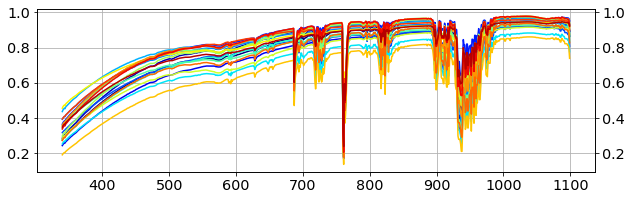

In [53]:
if FLAG_PLOT:
    N=20
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    fig=plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)
    for idx in np.arange(N):
        ax.plot(wl,transm[idx,:],c=all_colors[idx])
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax.grid()

In [54]:
NWL=wl.shape[0]

In [55]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

# Prepare data : X and Y

In [56]:
airmassarr=airmass[:,np.newaxis]
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=ozone[:,np.newaxis]
cldarr=cld[:,np.newaxis]

## Check atmosphere

In [57]:
def GetBouguerLinesAtm(Npoints,FLAG_PLOT=True):
    """
    """
    wl_sel=np.linspace(350,1000,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel ]
    NIWSEL=len(iwl_sel)
    Mags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=airmass
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        if FLAG_CLOUD:
            the_y=-2.5*np.log10(transm[:,iwl]*np.exp(-cld*airmass))
        else:
            the_y=-2.5*np.log10(transm[:,iwl])

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
    
        # fit
        z = np.polyfit(the_x, the_y, 1)
        Mags[idx]=z[-1]
        p = np.poly1d(z)
        y_fit=p(x_fit)
        
        if FLAG_PLOT:
            ax.plot(x_fit,y_fit,'-',color=all_colors[idx])
    
    
    if FLAG_PLOT:
        ax.legend()
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("log transmission atmosphere (mag)")
        ax.set_title("log of atmospheric transmission vs airmass")
        plt.show()
     
    return wl_sel,Mags
     

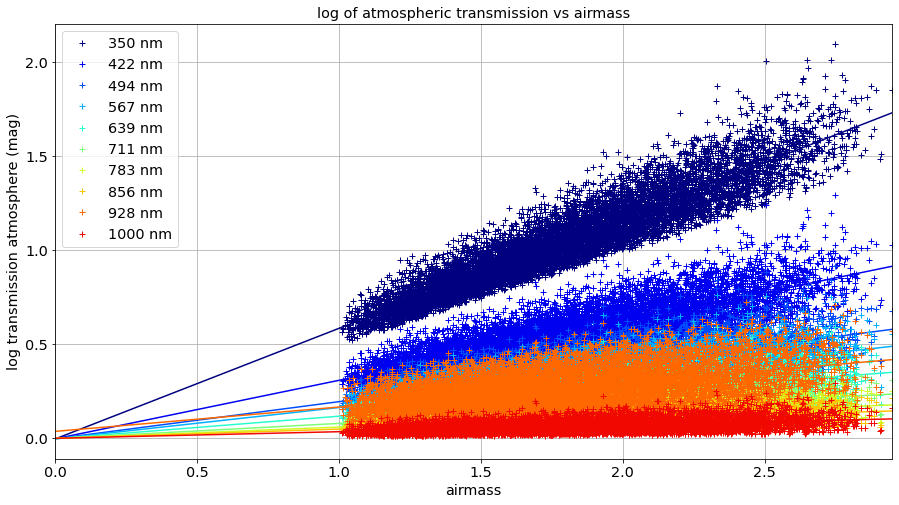

(array([ 350.        ,  422.22222222,  494.44444444,  566.66666667,
         638.88888889,  711.11111111,  783.33333333,  855.55555556,
         927.77777778, 1000.        ]),
 array([-0.00511048, -0.00431821, -0.00387759, -0.00459948, -0.00348781,
        -0.00212426, -0.00187669, -0.00150086,  0.03561656, -0.00108176]))

In [58]:
FLAG_CLOUD=False
GetBouguerLinesAtm(10,FLAG_PLOT=True)

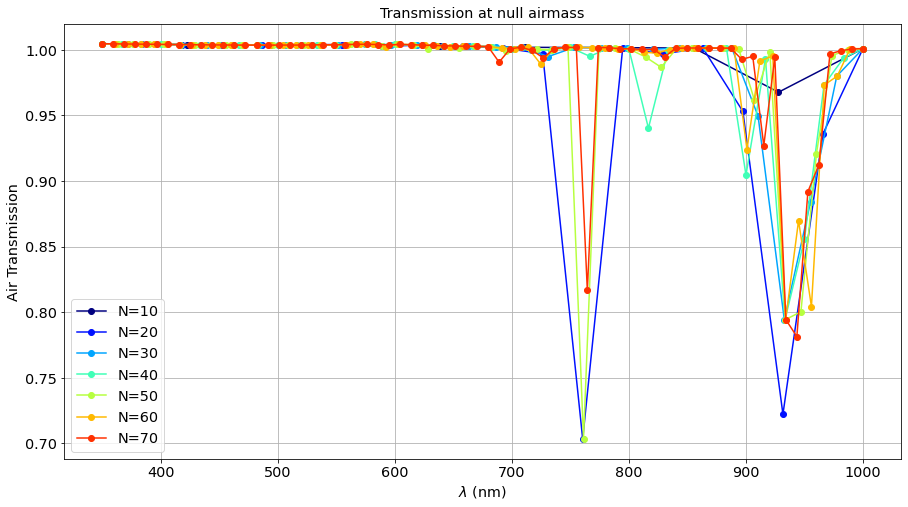

In [59]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(15,8))
    ax=fig.add_subplot(111)
    
    
    NPOINTS=np.arange(10,80,10)
    NNPOINTS=len(NPOINTS)
    
    N=NNPOINTS
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    for idx in np.arange(NNPOINTS):
        npoints=NPOINTS[idx]
        label=f"N={npoints}"
        w,m=GetBouguerLinesAtm(npoints,False)
        

        ax.plot(w,np.power(10,-m/2.5),'o-',color=all_colors[idx],label=label)

   
    ax.legend()
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("Air Transmission")
    ax.set_title("Transmission at null airmass")

## Clouds

## clouds in input data

In [60]:
transm_cloud=np.exp(-cld*airmass)
transm_cloud_arr=np.exp(-cldarr*airmassarr)

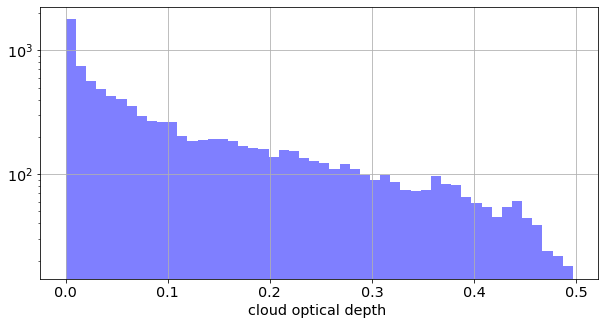

In [61]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(10,5))

    ax = fig.add_subplot(111)
    ax.hist(cld,bins=50,facecolor="b",label="in data",alpha=0.5)
    ax.set_yscale('log')
    ax.set_xlabel("cloud optical depth ")
    ax.grid()


### concatenate VAOD,PWV, Ozone

In [62]:
Y=np.concatenate((vaodarr,pwvarr,o3arr,cldarr),axis=1)
Ylabel=["vaod","pwv","ozone","cld"]

### Use magnitudes for X

In [63]:
t=GetListOfCalspec()
t_sel=SelectFewSED(t)

In [64]:
t_sel

<Table length=8>
 OBJNAME     RA     DEC   SP_TYPE SP_QUAL ...  calcR   calcI    factor     VmI  
 bytes10  float64 float64 bytes12  bytes1 ... float64 float64  float64   float64
--------- ------- ------- ------- ------- ... ------- ------- ---------- -------
  NGC7293 337.411 -20.837   DAO.5       C ...  13.734  14.234      26.01  -0.697
   G93-48 328.106   2.389   DA2.8       C ...  12.836  13.234      12.34  -0.506
      HZ4  58.842   9.788   DA3.4       C ...  14.569  14.723     61.551  -0.250
ALPHA_LYR 279.235  38.784    A0Va       C ...   0.000  -0.004 0.00010079   0.013
 HD163466 268.106  60.396      A2       E ...   6.694   6.589   0.054409   0.251
 HD074000 130.212 -16.345      F2       D ...   9.269   8.987    0.72107   0.658
 HD106252 183.373  10.042      G0       E ...   6.957   6.653   0.091453   0.750
     FLAT   0.000   0.000    flat       0 ...   9.501   9.001          1   0.999

### Show examples of SED to use

2020-09-22 23:34:50,560 MacBook-Pro-de-admin.local astropy[93411] WARNING VerifyWarning: Invalid keyword for column 1: Column disp option (TDISPn) failed verification: Format 26A is not recognized. The invalid value will be ignored for the purpose of formatting the data in this column.
2020-09-22 23:34:50,564 MacBook-Pro-de-admin.local astropy[93411] WARNING VerifyWarning: Invalid keyword for column 2: Column disp option (TDISPn) failed verification: Format 18A is not recognized. The invalid value will be ignored for the purpose of formatting the data in this column.
2020-09-22 23:34:50,568 MacBook-Pro-de-admin.local astropy[93411] WARNING VerifyWarning: Invalid keyword for column 3: Column disp option (TDISPn) failed verification: Format 56A is not recognized. The invalid value will be ignored for the purpose of formatting the data in this column.
2020-09-22 23:34:50,574 MacBook-Pro-de-admin.local astropy[93411] WARNING VerifyWarning: Invalid keyword for column 4: Column disp option (

Warning, 44 of 7210 bins contained negative fluxes; they have been set to zero.
Warning, 19 of 6265 bins contained negative fluxes; they have been set to zero.


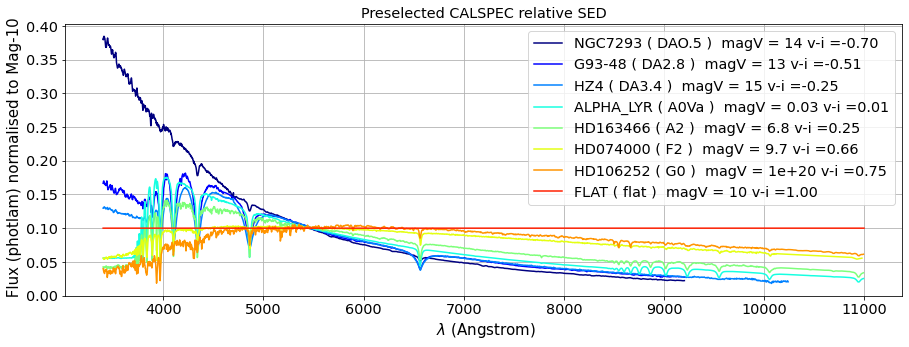

In [65]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(15,5))
    ax=fig.add_subplot(111)
    plot_sed(t_sel,ax)
    plt.show()

### Get the Spectrum

### define the filenames

In [66]:
idx_sed_sel=3
sed_filename=t_sel[idx_sed_sel]["FILES"]
sed_objname=t_sel[idx_sed_sel]["OBJNAME"]
sed_fullfilename=os.path.join(path_sed_calspec,sed_filename)
############
order2=True
cut=True
############
if order2 and not cut:
    specarrayfile="spec_"+sed_objname+"_ord12.npy"
    specarrayfile2="spec2_"+sed_objname+"_ord2.npy"
    
    specarrayfile3="spec_noatmnoqe_"+sed_objname+"_ord12.npy"
    specarrayfile4="spec2_noatmnoqe_"+sed_objname+"_ord2.npy"
    
    
    title_spec1="spectra order 1 and 2"
    title_spec2="spectra order 2"
    
    title_spec3="spectra order 1 and 2 no atm no qe"
    title_spec4="spectra order 2 no atm no qe"
elif order2 and cut:
    specarrayfile="speccut_"+sed_objname+"_ord12.npy"
    specarrayfile2="spec2cut_"+sed_objname+"_ord2.npy"
    
    specarrayfile3="speccut_noatmnoqe_"+sed_objname+"_ord12.npy"
    specarrayfile4="spec2cut_noatmnoqe_"+sed_objname+"_ord2.npy"
    
    
    title_spec1="spectra order 1 and 2"
    title_spec2="spectra order 2"
    
    title_spec3="spectra order 1 and 2 no atm no qe"
    title_spec4="spectra order 2 no atm no qe"    
    
    
else:
    specarrayfile="spec_"+sed_objname+"_ord1.npy"
    specarrayfile2="spec2_"+sed_objname+"_ord2.npy"
    title_spec1="spectra order 1"
    title_spec2="spectra order 2"
    
    specarrayfile3="spec_noatmnoqe_"+sed_objname+"_ord1.npy"
    specarrayfile4="spec2_noatmnoqe_"+sed_objname+"_ord2.npy"
    
    title_spec1="spectra order 1"
    title_spec2="spectra order 2"
    
    title_spec3="spectra order 1 no atm no qe"
    title_spec4="spectra order 2 no atm no qe"
    
    
    

In [67]:
specarrayfile

'speccut_ALPHA_LYR_ord12.npy'

In [68]:
specarrayfile2

'spec2cut_ALPHA_LYR_ord2.npy'

In [69]:
if sed_filename=="flat":
    flatsp = S.FlatSpectrum(10, fluxunits='photlam')
    spec=flatsp
else:
    spec=S.FileSpectrum(sed_fullfilename)
        
spec_norm = spec.renorm(10, 'vegamag', S.ObsBandpass('johnson,v'))
    
spec_norm.convert('photlam')

In [70]:
if not os.path.isfile(specarrayfile) or not os.path.isfile(specarrayfile2) :
    spectra,spectra2=GetSpectra(sed=spec_norm,wl_atm=wl,atm_transmission=transm,order2=order2,cut=cut)
    np.save(specarrayfile,spectra)
    np.save(specarrayfile2,spectra2)   
else:
    spectra=np.load(specarrayfile)
    spectra2=np.load(specarrayfile2)

2020-09-22 23:34:51,377 MacBook-Pro-de-admin.local numexpr.utils[93411] INFO NumExpr defaulting to 8 threads.


(((QE * atm0) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm0) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be us

(((QE * atm44) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm44) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm45) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm45) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm46) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm46) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm47) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm47) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum wi

(((QE * atm89) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm90) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm90) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm91) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm91) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm92) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm92) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm93) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum wi

(((QE * atm130) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm131) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm131) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm132) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm132) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm133) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm133) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm134) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm174) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm175) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm175) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm176) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm176) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm177) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm177) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm178) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm218) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm219) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm219) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm220) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm220) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm221) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm221) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm222) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm262) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm262) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm263) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm263) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm264) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm264) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm265) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm265) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm305) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm306) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm306) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm307) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm307) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm308) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm308) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm309) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm348) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm348) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm349) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm349) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm350) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm350) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm351) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm351) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm390) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm391) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm391) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm392) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm392) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm393) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm393) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm394) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm432) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm433) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm433) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm434) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm434) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm435) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm435) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm436) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm475) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm476) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm476) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm477) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm477) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm478) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm478) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm479) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm519) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm520) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm520) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm521) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm521) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm522) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm522) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm523) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm563) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm564) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm564) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm565) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm565) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm566) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm566) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm567) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm602) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm603) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm603) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm604) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm604) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm605) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm605) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm606) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm647) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm648) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm648) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm649) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm649) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm650) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm650) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm651) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm693) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm693) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm694) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm694) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm695) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm695) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm696) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm696) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm739) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm739) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm740) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm740) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm741) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm741) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm742) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm742) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm785) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm786) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm786) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm787) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm787) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm788) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm788) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm789) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm830) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm831) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm831) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm832) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm832) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm833) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm833) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm834) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm873) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm873) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm874) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm874) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm875) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm875) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm876) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm876) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm913) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm913) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm914) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm914) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm915) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm915) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm916) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm916) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm956) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm956) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm957) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm957) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm958) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm958) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm959) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm959) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm999) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm999) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1000) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1000) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1001) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1001) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1002) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1002) * Holo2)) does not have a defined binset in the wavecat table. The waveset of t

(((QE * atm1043) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1043) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1044) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1044) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1045) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1045) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1046) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1046) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1087) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1087) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1088) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1088) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1089) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1089) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1090) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1090) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1131) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1131) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1132) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1132) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1133) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1133) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1134) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1134) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1174) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1174) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1175) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1175) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1176) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1176) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1177) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1177) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1216) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1216) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1217) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1217) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1218) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1218) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1219) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1219) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1259) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1260) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1260) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1261) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1261) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1262) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1262) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1263) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1303) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1304) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1304) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1305) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1305) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1306) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1306) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1307) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1364) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1365) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1365) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1366) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1366) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1367) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1367) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1368) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1409) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1410) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1410) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1411) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1411) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1412) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1412) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1413) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1452) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1453) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1453) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1454) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1454) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1455) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1455) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1456) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1497) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1497) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1498) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1498) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1499) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1499) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1500) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1500) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1537) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1538) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1538) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1539) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1539) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1540) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1540) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1541) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1578) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1578) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1579) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1579) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1580) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1580) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1581) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1581) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1624) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1625) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1625) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1626) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1626) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1627) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1627) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1628) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1692) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1692) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1693) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1693) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1694) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1694) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1695) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1695) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1733) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1733) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1734) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1734) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1735) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1735) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1736) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1736) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1774) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1775) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1775) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1776) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1776) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1777) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1777) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1778) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1818) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1819) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1819) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1820) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1820) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1821) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1821) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1822) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1860) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1860) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1861) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1861) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1862) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1862) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1863) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1863) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1905) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1905) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1906) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1906) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1907) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1907) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1908) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1908) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1940) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1941) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1941) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1942) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1942) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1943) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1943) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1944) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2010) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2010) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2011) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2011) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2012) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2012) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2013) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2013) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2053) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2053) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2054) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2054) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2055) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2055) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2056) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2056) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2096) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2097) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2097) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2098) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2098) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2099) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2099) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2100) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2137) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2138) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2138) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2139) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2139) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2140) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2140) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2141) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2183) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2184) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2184) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2185) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2185) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2186) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2186) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2187) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2228) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2229) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2229) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2230) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2230) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2231) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2231) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2232) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2273) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2273) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2274) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2274) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2275) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2275) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2276) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2276) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2317) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2317) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2318) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2318) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2319) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2319) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2320) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2320) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2361) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2362) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2362) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2363) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2363) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2364) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2364) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2365) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2401) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2402) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2402) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2403) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2403) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2404) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2404) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2405) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2441) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2441) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2442) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2442) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2443) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2443) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2444) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2444) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2479) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2480) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2480) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2481) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2481) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2482) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2482) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2483) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2516) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2516) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2517) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2517) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2518) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2518) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2519) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2519) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2550) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2551) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2551) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2552) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2552) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2553) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2553) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2554) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2620) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2621) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2621) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2622) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2622) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2623) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2623) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2624) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2664) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2664) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2665) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2665) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2666) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2666) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2667) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2667) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2709) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2710) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2710) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2711) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2711) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2712) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2712) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2713) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2754) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2754) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2755) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2755) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2756) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2756) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2757) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2757) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2823) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2824) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2824) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2825) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2825) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2826) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2826) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2827) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2866) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2867) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2867) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2868) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2868) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2869) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2869) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2870) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2903) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2904) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2904) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2905) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2905) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2906) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2906) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2907) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2939) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2939) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2940) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2940) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2941) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2941) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2942) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2942) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2971) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2972) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2972) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2973) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2973) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2974) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2974) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2975) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3015) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3016) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3016) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3017) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3017) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3018) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3018) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3019) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3063) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3063) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3064) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3064) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3065) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3065) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3066) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3066) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3109) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3110) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3110) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3111) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3111) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3112) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3112) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3113) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3156) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3156) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3157) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3157) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3158) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3158) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3159) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3159) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3198) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3198) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3199) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3199) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3200) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3200) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3201) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3201) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3245) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3245) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3246) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3246) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3247) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3247) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3248) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3248) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3288) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3289) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3289) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3290) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3290) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3291) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3291) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3292) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3331) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3332) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3332) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3333) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3333) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3334) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3334) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3335) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3376) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3377) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3377) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3378) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3378) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3379) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3379) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3380) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3422) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3423) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3423) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3424) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3424) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3425) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3425) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3426) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3467) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3467) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3468) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3468) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3469) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3469) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3470) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3470) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3506) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3507) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3507) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3508) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3508) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3509) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3509) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3510) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3551) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3552) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3552) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3553) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3553) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3554) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3554) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3555) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3596) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3597) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3597) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3598) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3598) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3599) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3599) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3600) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3636) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3637) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3637) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3638) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3638) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3639) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3639) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3640) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3675) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3676) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3676) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3677) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3677) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3678) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3678) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3679) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3715) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3716) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3716) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3717) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3717) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3718) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3718) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3719) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3750) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3751) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3751) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3752) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3752) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3753) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3753) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3754) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3790) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3791) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3791) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3792) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3792) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3793) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3793) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3794) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3834) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3835) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3835) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3836) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3836) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3837) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3837) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3838) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3876) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3876) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3877) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3877) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3878) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3878) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3879) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3879) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3919) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3919) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3920) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3920) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3921) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3921) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3922) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3922) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3957) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3958) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3958) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3959) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3959) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3960) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3960) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3961) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4002) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4002) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4003) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4003) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4004) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4004) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4005) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4005) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4047) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4047) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4048) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4048) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4049) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4049) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4050) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4050) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4092) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4093) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4093) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4094) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4094) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4095) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4095) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4096) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4136) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4136) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4137) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4137) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4138) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4138) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4139) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4139) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4180) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4181) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4181) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4182) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4182) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4183) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4183) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4184) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4225) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4226) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4226) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4227) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4227) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4228) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4228) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4229) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4271) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4271) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4272) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4272) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4273) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4273) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4274) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4274) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4316) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4316) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4317) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4317) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4318) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4318) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4319) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4319) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4360) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4361) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4361) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4362) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4362) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4363) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4363) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4364) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4403) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4403) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4404) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4404) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4405) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4405) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4406) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4406) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4447) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4448) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4448) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4449) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4449) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4450) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4450) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4451) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4490) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4490) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4491) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4491) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4492) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4492) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4493) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4493) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4533) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4533) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4534) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4534) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4535) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4535) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4536) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4536) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4574) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4574) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4575) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4575) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4576) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4576) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4577) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4577) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4611) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4611) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4612) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4612) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4613) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4613) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4614) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4614) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4654) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4655) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4655) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4656) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4656) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4657) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4657) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4658) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4700) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4700) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4701) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4701) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4702) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4702) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4703) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4703) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4744) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4744) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4745) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4745) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4746) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4746) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4747) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4747) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4788) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4789) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4789) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4790) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4790) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4791) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4791) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4792) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4834) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4834) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4835) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4835) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4836) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4836) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4837) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4837) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4878) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4879) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4879) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4880) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4880) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4881) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4881) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4882) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4923) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4924) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4924) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4925) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4925) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4926) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4926) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4927) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4966) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4967) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4967) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4968) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4968) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4969) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4969) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4970) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5011) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5012) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5012) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5013) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5013) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5014) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5014) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5015) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5057) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5058) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5058) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5059) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5059) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5060) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5060) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5061) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5102) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5103) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5103) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5104) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5104) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5105) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5105) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5106) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5147) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5147) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5148) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5148) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5149) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5149) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5150) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5150) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5190) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5191) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5191) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5192) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5192) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5193) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5193) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5194) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5235) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5235) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5236) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5236) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5237) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5237) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5238) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5238) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5280) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5281) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5281) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5282) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5282) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5283) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5283) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5284) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5325) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5325) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5326) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5326) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5327) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5327) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5328) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5328) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5370) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5370) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5371) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5371) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5372) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5372) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5373) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5373) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5414) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5414) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5415) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5415) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5416) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5416) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5417) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5417) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5458) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5459) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5459) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5460) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5460) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5461) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5461) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5462) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5501) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5502) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5502) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5503) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5503) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5504) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5504) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5505) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5546) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5547) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5547) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5548) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5548) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5549) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5549) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5550) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5589) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5589) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5590) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5590) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5591) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5591) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5592) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5592) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5632) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5632) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5633) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5633) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5634) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5634) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5635) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5635) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5677) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5677) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5678) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5678) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5679) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5679) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5680) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5680) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5722) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5722) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5723) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5723) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5724) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5724) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5725) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5725) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5765) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5766) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5766) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5767) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5767) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5768) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5768) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5769) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5811) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5811) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5812) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5812) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5813) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5813) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5814) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5814) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5853) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5853) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5854) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5854) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5855) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5855) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5856) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5856) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5898) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5898) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5899) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5899) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5900) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5900) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5901) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5901) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5942) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5943) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5943) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5944) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5944) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5945) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5945) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5946) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5987) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5987) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5988) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5988) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5989) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5989) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5990) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5990) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6032) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6033) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6033) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6034) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6034) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6035) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6035) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6036) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6076) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6076) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6077) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6077) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6078) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6078) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6079) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6079) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6121) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6122) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6122) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6123) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6123) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6124) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6124) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6125) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6167) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6167) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6168) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6168) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6169) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6169) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6170) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6170) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6212) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6212) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6213) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6213) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6214) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6214) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6215) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6215) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6257) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6257) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6258) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6258) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6259) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6259) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6260) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6260) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6300) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6300) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6301) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6301) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6302) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6302) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6303) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6303) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6344) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6345) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6345) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6346) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6346) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6347) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6347) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6348) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6390) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6390) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6391) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6391) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6392) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6392) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6393) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6393) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6435) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6436) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6436) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6437) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6437) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6438) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6438) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6439) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6480) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6481) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6481) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6482) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6482) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6483) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6483) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6484) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6519) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6519) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6520) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6520) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6521) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6521) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6522) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6522) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6562) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6562) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6563) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6563) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6564) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6564) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6565) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6565) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6603) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6604) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6604) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6605) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6605) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6606) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6606) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6607) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6645) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6645) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6646) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6646) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6647) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6647) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6648) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6648) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6686) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6687) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6687) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6688) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6688) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6689) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6689) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6690) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6726) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6726) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6727) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6727) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6728) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6728) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6729) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6729) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6769) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6770) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6770) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6771) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6771) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6772) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6772) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6773) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6813) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6814) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6814) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6815) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6815) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6816) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6816) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6817) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6853) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6853) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6854) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6854) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6855) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6855) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6856) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6856) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6887) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6888) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6888) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6889) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6889) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6890) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6890) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6891) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6932) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6933) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6933) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6934) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6934) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6935) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6935) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6936) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6977) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6978) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6978) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6979) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6979) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6980) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6980) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6981) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7012) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7013) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7013) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7014) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7014) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7015) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7015) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7016) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7056) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7057) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7057) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7058) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7058) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7059) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7059) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7060) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7101) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7101) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7102) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7102) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7103) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7103) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7104) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7104) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7143) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7144) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7144) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7145) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7145) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7146) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7146) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7147) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7189) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7189) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7190) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7190) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7191) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7191) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7192) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7192) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7233) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7234) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7234) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7235) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7235) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7236) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7236) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7237) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7276) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7277) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7277) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7278) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7278) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7279) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7279) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7280) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7319) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7320) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7320) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7321) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7321) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7322) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7322) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7323) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7363) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7364) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7364) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7365) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7365) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7366) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7366) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7367) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7408) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7408) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7409) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7409) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7410) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7410) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7411) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7411) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7451) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7451) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7452) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7452) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7453) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7453) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7454) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7454) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7494) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7494) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7495) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7495) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7496) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7496) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7497) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7497) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7537) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7538) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7538) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7539) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7539) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7540) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7540) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7541) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7582) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7582) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7583) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7583) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7584) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7584) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7585) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7585) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7626) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7627) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7627) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7628) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7628) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7629) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7629) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7630) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7670) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7671) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7671) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7672) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7672) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7673) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7673) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7674) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7714) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7715) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7715) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7716) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7716) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7717) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7717) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7718) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7758) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7759) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7759) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7760) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7760) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7761) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7761) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7762) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7801) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7801) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7802) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7802) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7803) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7803) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7804) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7804) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7845) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7845) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7846) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7846) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7847) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7847) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7848) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7848) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7888) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7888) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7889) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7889) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7890) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7890) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7891) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7891) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7931) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7932) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7932) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7933) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7933) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7934) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7934) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7935) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7975) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7975) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7976) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7976) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7977) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7977) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7978) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7978) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8018) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8019) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8019) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8020) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8020) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8021) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8021) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8022) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8058) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8059) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8059) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8060) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8060) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8061) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8061) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8062) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8099) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8099) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8100) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8100) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8101) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8101) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8102) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8102) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8142) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8142) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8143) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8143) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8144) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8144) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8145) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8145) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8186) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8187) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8187) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8188) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8188) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8189) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8189) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8190) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8231) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8231) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8232) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8232) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8233) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8233) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8234) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8234) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8275) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8276) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8276) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8277) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8277) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8278) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8278) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8279) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8318) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8318) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8319) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8319) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8320) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8320) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8321) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8321) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8360) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8360) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8361) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8361) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8362) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8362) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8363) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8363) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8404) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8405) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8405) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8406) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8406) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8407) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8407) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8408) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8448) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8449) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8449) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8450) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8450) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8451) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8451) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8452) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8491) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8491) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8492) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8492) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8493) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8493) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8494) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8494) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8535) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8535) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8536) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8536) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8537) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8537) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8538) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8538) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8577) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8577) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8578) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8578) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8579) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8579) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8580) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8580) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8618) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8618) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8619) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8619) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8620) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8620) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8621) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8621) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8656) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8657) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8657) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8658) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8658) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8659) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8659) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8660) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8697) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8697) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8698) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8698) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8699) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8699) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8700) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8700) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8729) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8730) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8730) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8731) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8731) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8732) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8732) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8733) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8766) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8766) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8767) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8767) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8768) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8768) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8769) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8769) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8809) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8809) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8810) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8810) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8811) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8811) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8812) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8812) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8845) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8845) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8846) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8846) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8847) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8847) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8848) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8848) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8891) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8891) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8892) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8892) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8893) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8893) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8894) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8894) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8936) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8936) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8937) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8937) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8938) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8938) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8939) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8939) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8978) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8979) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8979) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8980) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8980) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8981) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8981) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8982) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9022) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9022) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9023) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9023) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9024) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9024) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9025) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9025) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9065) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9066) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9066) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9067) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9067) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9068) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9068) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9069) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9107) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9107) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9108) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9108) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9109) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9109) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9110) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9110) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9151) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9151) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9152) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9152) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9153) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9153) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9154) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9154) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9194) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9195) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9195) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9196) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9196) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9197) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9197) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9198) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9238) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9239) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9239) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9240) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9240) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9241) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9241) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9242) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9283) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9284) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9284) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9285) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9285) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9286) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9286) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9287) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9328) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9328) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9329) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9329) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9330) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9330) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9331) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9331) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9372) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9373) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9373) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9374) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9374) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9375) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9375) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9376) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9415) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9416) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9416) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9417) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9417) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9418) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9418) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9419) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9459) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9460) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9460) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9461) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9461) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9462) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9462) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9463) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9503) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9504) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9504) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9505) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9505) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9506) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9506) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9507) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9548) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9548) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9549) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9549) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9550) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9550) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9551) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9551) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9593) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9593) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9594) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9594) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9595) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9595) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9596) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9596) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9637) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9637) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9638) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9638) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9639) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9639) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9640) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9640) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9680) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9680) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9681) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9681) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9682) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9682) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9683) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9683) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9722) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9722) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9723) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9723) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9724) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9724) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9725) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9725) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9772) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9772) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9773) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9773) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9774) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9774) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9775) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9775) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9811) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9811) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9812) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9812) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9813) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9813) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9814) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9814) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9849) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9850) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9850) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9851) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9851) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9852) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9852) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9853) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9892) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9893) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9893) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9894) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9894) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9895) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9895) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9896) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9936) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9937) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9937) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9938) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9938) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9939) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9939) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9940) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9979) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9980) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9980) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9981) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9981) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9982) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9982) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9983) * Holo)) does not have a defined binset in the wavecat table. The waveset of

In [71]:
if not os.path.isfile(specarrayfile3) or not os.path.isfile(specarrayfile4) :
    spectra3,spectra4=GetSpectraNoAtm(sed=spec_norm,wl_atm=wl,atm_transmission=transm,order2=order2,cut=cut)
    np.save(specarrayfile3,spectra3)
    np.save(specarrayfile4,spectra4)   
else:
    spectra3=np.load(specarrayfile3)
    spectra4=np.load(specarrayfile4)

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Holo2

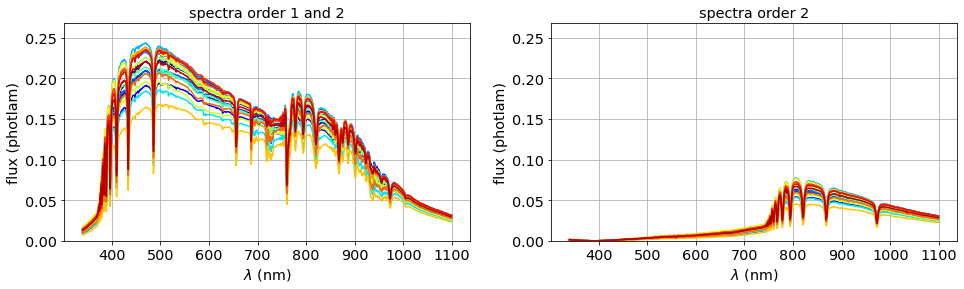

In [72]:
if FLAG_PLOT:
    
    N=20
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    themax=0
    themin=0
    
    fig=plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    for idx in np.arange(N):
        if spectra[idx,:].max()>themax:
            themax=spectra[idx,:].max()
        ax.plot(wl,spectra[idx,:],color=all_colors[idx])
    ax.set_ylim(0,1.1*themax)
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("flux (photlam)")
    ax.set_title(title_spec1)
    
    ax = fig.add_subplot(122)
    for idx in np.arange(N):
        ax.plot(wl,spectra2[idx,:],color=all_colors[idx])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("flux (photlam)")
    ax.set_ylim(0,1.1*themax)
    ax.set_title(title_spec2)
    ax.grid()

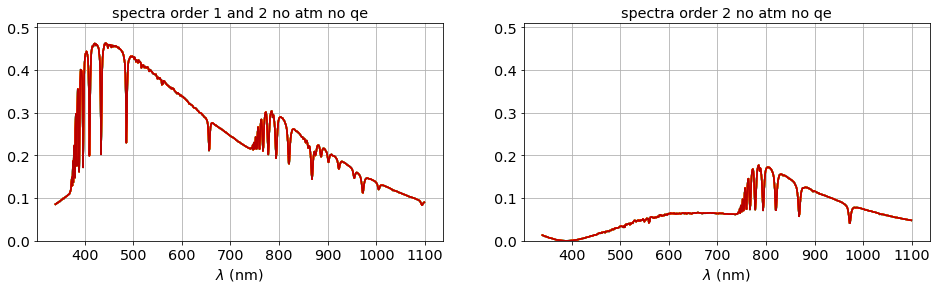

In [73]:
if FLAG_PLOT:
    
    N=20
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    themax=0
    themin=0
    
    fig=plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    for idx in np.arange(N):
        if spectra3[idx,:].max()>themax:
            themax=spectra3[idx,:].max()
        ax.plot(wl,spectra3[idx,:],color=all_colors[idx])
    ax.set_ylim(0,1.1*themax)
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_title(title_spec3)
    
    ax = fig.add_subplot(122)
    for idx in np.arange(N):
        ax.plot(wl,spectra4[idx,:],color=all_colors[idx])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylim(0,1.1*themax)
    ax.set_title(title_spec4)
    ax.grid()

In [74]:
FLAG_CLOUD=True

if FLAG_CLOUD:
    X=-2.5*(np.log10(spectra*transm_cloud_arr)-np.log10(spectra3))
else:
    X=-2.5*(np.log10(spectra)-np.log10(spectra3))

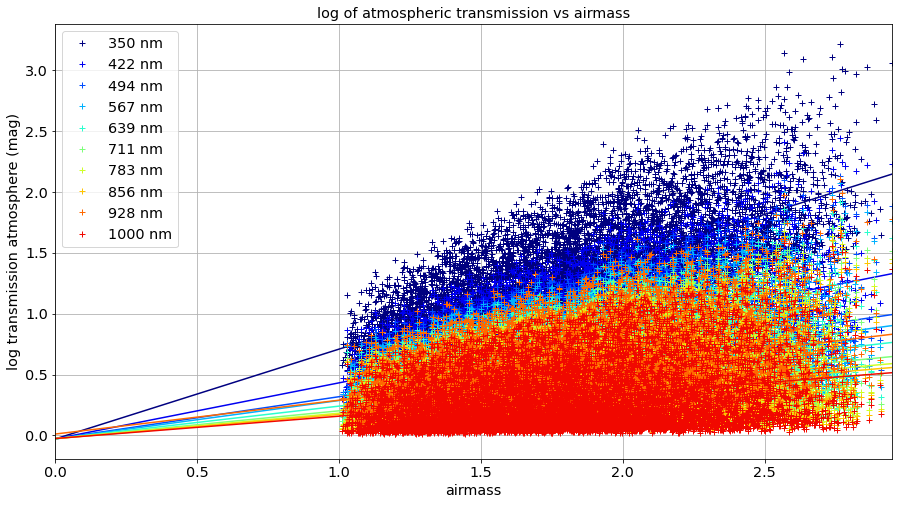

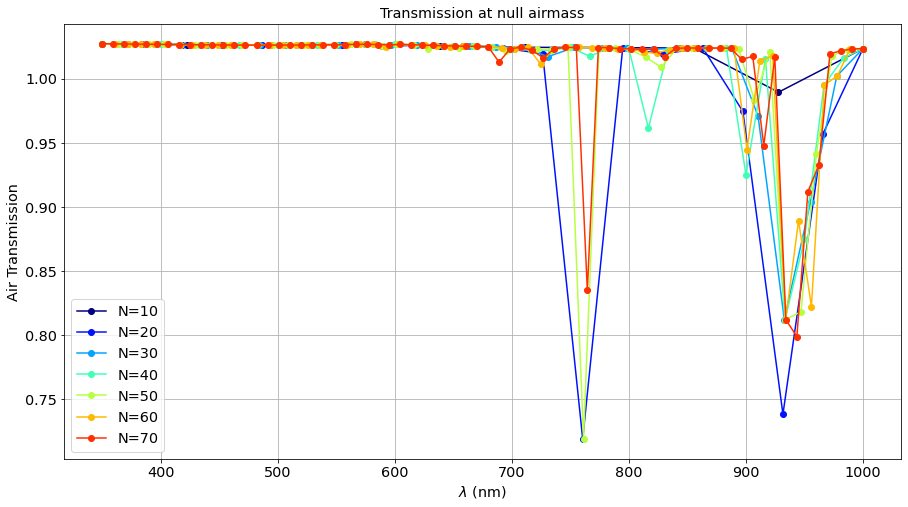

In [75]:
if FLAG_CLOUD:
    
    GetBouguerLinesAtm(10,FLAG_PLOT=True)
    
    
if FLAG_PLOT and FLAG_CLOUD:
    fig=plt.figure(figsize=(15,8))
    ax=fig.add_subplot(111)
    
    
    NPOINTS=np.arange(10,80,10)
    NNPOINTS=len(NPOINTS)
    
    N=NNPOINTS
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    for idx in np.arange(NNPOINTS):
        npoints=NPOINTS[idx]
        label=f"N={npoints}"
        w,m=GetBouguerLinesAtm(npoints,False)
        

        ax.plot(w,np.power(10,-m/2.5),'o-',color=all_colors[idx],label=label)

   
    ax.legend()
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("Air Transmission")
    ax.set_title("Transmission at null airmass")
    

### Check transmission or spectrum

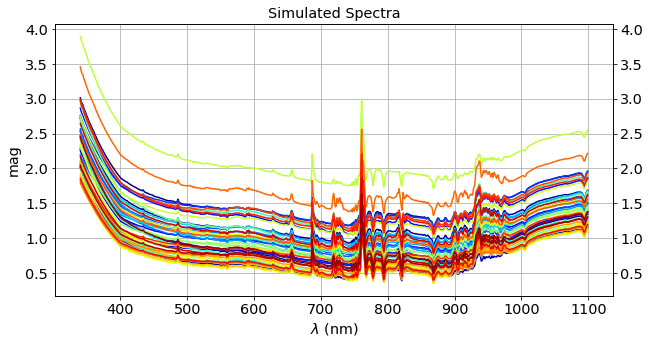

In [76]:
if FLAG_PLOT:
    N=50
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)


    fig=plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    for idx in np.arange(N):
        ax.plot(wl,X[idx,:],color=all_colors[idx])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("mag")
    ax.set_title("Simulated Spectra")
    ax.grid()
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())

# Correlation coefficient X - Y

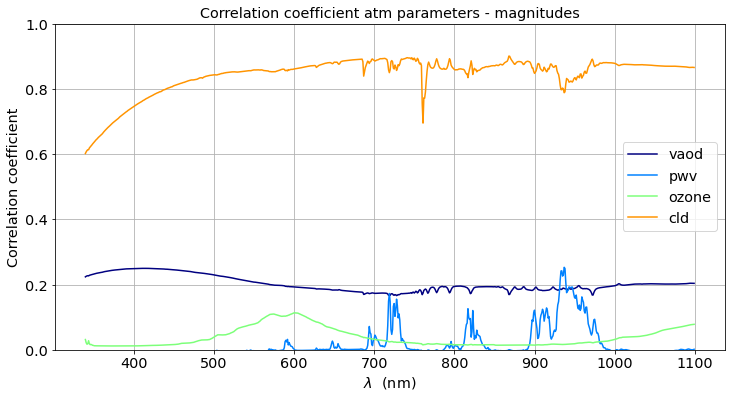

In [77]:
if FLAG_PLOT:
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111) 
    
    Ny=Y.shape[1]
    Nx=X.shape[1]
    
    N=Ny
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    corr=np.zeros((Ny,Nx))
    
    for iy in np.arange(Ny):
        y=Y[:,iy]
        
        for ix in np.arange(Nx):
            x=X[:,ix]
            R=np.corrcoef(x=x, y=y, rowvar=False)
            corr[iy,ix]=R[0,1]
            
        ax.plot(wl,corr[iy,:],color=all_colors[iy],label=Ylabel[iy])
            
    ax.legend()
    ax.set_xlabel("$\lambda$  (nm)")
    ax.set_ylabel("Correlation coefficient")
    ax.set_title("Correlation coefficient atm parameters - magnitudes")
    ax.grid()
    ax.set_ylim(0,1)

# Bouguer Lines

In [78]:
def GetBouguerLines(Npoints,FLAG_PLOT=True):
    """
    """
    wl_sel=np.linspace(350,1000,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel ]
    NIWSEL=len(iwl_sel)
    Mags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=airmass
    the_y=X[:,iwl_sel]
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        the_y=X[:,iwl]

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
    
        # fit
        z = np.polyfit(the_x, the_y, 1)
        Mags[idx]=z[-1]
        p = np.poly1d(z)
        y_fit=p(x_fit)
        
        if FLAG_PLOT:
            ax.plot(x_fit,y_fit,'-',color=all_colors[idx])
    
    
    if FLAG_PLOT:
        ax.legend()
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("magnitude (mag)")
        ax.set_title("magnitude vs airmass (SED and holo transmission subtracted)")
        plt.show()
    
    
    
    return wl_sel,Mags
    
  

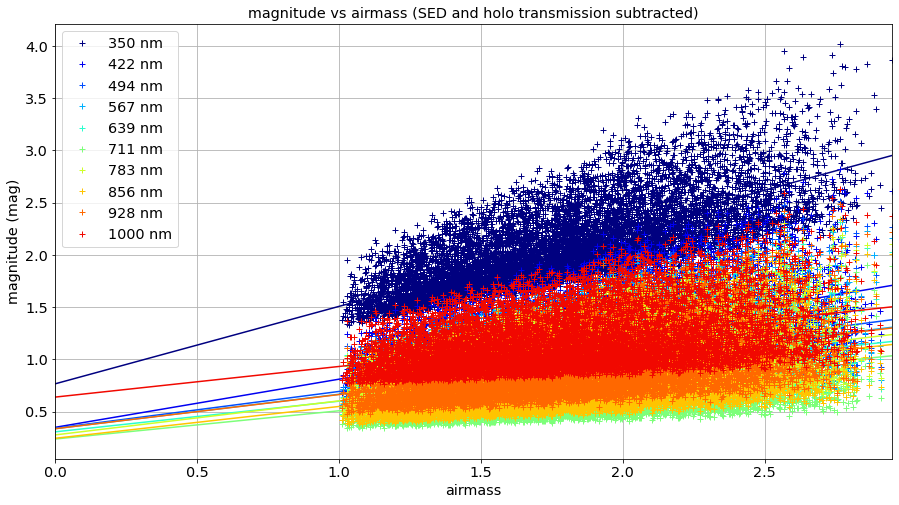

In [79]:
w10,m10=GetBouguerLines(10,True)

In [80]:
# quantum efficiency
wl_ccd,throughput,ccdqe,trans_opt_elec=lsst.GetThroughputAndCCDQE("../../data/lsst")

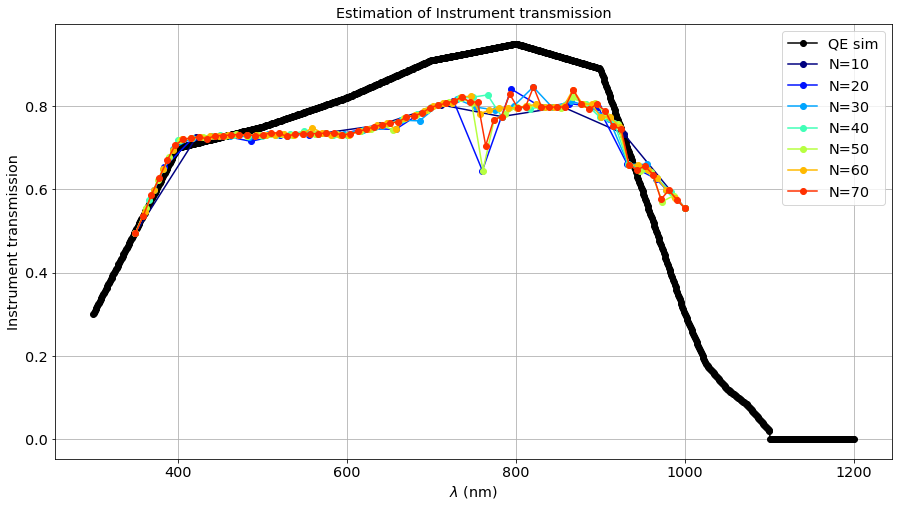

In [81]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(15,8))
    ax=fig.add_subplot(111)
    
    ax.plot(wl_ccd,ccdqe,'o-k',label="QE sim")
    
    NPOINTS=np.arange(10,80,10)
    NNPOINTS=len(NPOINTS)
    
    N=NNPOINTS
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    for idx in np.arange(NNPOINTS):
        npoints=NPOINTS[idx]
        label=f"N={npoints}"
        w,m=GetBouguerLines(npoints,False)
        

        ax.plot(w,np.power(10,-m/2.5),'o-',color=all_colors[idx],label=label)

   
    ax.legend()
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("Instrument transmission")
    ax.set_title("Estimation of Instrument transmission")